<a href="https://colab.research.google.com/github/andreaskuepfer/python-for-social-scientists/blob/main/Day%202/day_2_python_for_social_scientists_SSDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Workshop Day 2: Python for Social Scientists at SSDL Methods Lab

Today we want to work with a Survey dataset from the *National Longitudinal Survey of Youth*. More information on the dataset can be found [here](https://https://www.nlsinfo.org/content/cohorts/nlsy79). For demonstration purposes we focus on the observation year 2015.

This workshop is divided into four sections:

1. First, we have to load the dataset into Python and take a look at its specifics.
2. Second, we are going to apply a logistic regression model based on the machine learning library `scikit-learn` for Python.
3. Third, we stick to `scikit-learn` but work with a random forest model.
4. Last and but least we wrap everything up with a short conclusion including an interpretation of the applied models and which further steps could be applied now.

### Load the Dataset & Explore the Data

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


The following packages are all we need for this workshop:

* `pandas` (https://pandas.pydata.org/docs/)
* `pyreadr` (https://pypi.org/project/pyreadr/)
* `sklearn` (https://scikit-learn.org/stable/)

They can be automatically installed (if not available) using the package manager pip and the following code chunk:

In [34]:
import importlib.util
import os

# Check for missing packages
def check_pkg(package):
  if importlib.util.find_spec(package):
    return(f"{package} already in sys.modules")
  else:
    os.system("pip install {0}".format(package))
    return(f"{package} installed.")

packages = ["pandas", "matplotlib", "pyreadr", "sklearn", "seaborn"]
[check_pkg(package) for package in packages]

['pandas already in sys.modules',
 'matplotlib already in sys.modules',
 'pyreadr already in sys.modules',
 'sklearn already in sys.modules',
 'seaborn already in sys.modules']

In [319]:
# Import needed function
from pyreadr import read_r
# Alternative to import all functions from a package:
# import pyreadr

# Call read_r function to read .rds file
nlsy_survey = read_r("/content/drive/MyDrive/SSDL_Python_Workshop/NLSY97.rds")
# As the result is a dictionary (keys = name of objects, values = python objects)
# in our case we have only one python object which key is None
nlsy_survey = nlsy_survey[None]
# Filter for the year 2015
nlsy_survey = nlsy_survey.loc[nlsy_survey["year"] == 2010]

In [329]:
# Take a look at the dataset with .head()
nlsy_survey.head()

,id,year,gender,ethnicity,educ_mo,educ_fa,citizen_birth,health,exercise,smoke,...,urban,educ,citizen_current,fruit,vegt,comp,tele,sleep,insured,age
0,4,2010,1,2,12,12,3,2,NaN,0,...,1,2,1,1,2,6,1,6,1,29
1,5,2010,0,2,12,12,3,1,NaN,1,...,1,2,1,3,5,2,2,7,1,28
2,6,2010,1,2,12,NaN,1,0,NaN,0,...,1,2,1,2,3,3,1,6,1,28
3,11,2010,1,2,14,12,1,3,NaN,1,...,1,2,1,1,2,6,2,4,1,28
4,16,2010,0,2,11,10,3,4,NaN,0,...,1,3,1,3,2,6,4,7,1,28


In [64]:
# Display all columns of the dataset
nlsy_survey.columns

Index(['id', 'year', 'gender', 'ethnicity', 'educ_mo', 'educ_fa',
       'citizen_birth', 'health', 'exercise', 'smoke', 'smoke_days', 'alc',
       'alc_days', 'income', 'income_fam', 'hh_size', 'income_hr', 'marry',
       'n_kids', 'urban', 'educ', 'citizen_current', 'fruit', 'vegt', 'comp',
       'tele', 'sleep', 'insured', 'age'],
      dtype='object')

We want to analyze, which variables do explain whether someone smokes or not. Thus, we first check out the distribution of values for the outcome.

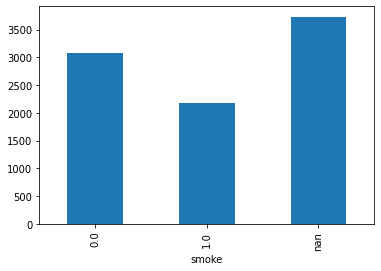

In [279]:
# Group and count the data by category
grouped_smoke_categeories = nlsy_survey.groupby(by="smoke", dropna=False).size()
# Plot the distribution in a simple bar chart
grouped_smoke_categeories.plot.bar()

There is a large number of "nan"-Values in this column. For the purpose of this workshop we drop them. However, you could also keep them and try to understand observations where the respondent did not reply.

In [322]:
# Filter the dataset for rows which contain a value for smoke
nlsy_survey = nlsy_survey.loc[nlsy_survey["smoke"].notna(), ]
# Check wether the filter worked
nlsy_survey.loc[~nlsy_survey["smoke"].notna(), ]

,id,year,gender,ethnicity,educ_mo,educ_fa,citizen_birth,health,exercise,smoke,...,urban,educ,citizen_current,fruit,vegt,comp,tele,sleep,insured,age


What about our predictors?

* Gender
* Alcohol
* Number of kids

Let's check their distributions also and create a function to simplify the plot generation.

In [203]:
def distribution_plot(column_name: str,
                      column_label: str,
                      ticks_label: list = None) -> None:
  # Group and count the data by category
  grouped_categeories = nlsy_survey.groupby(by=column_name, dropna=False).size()
  
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_ylabel("Count")
  ax.set_xlabel(column_label)
  ax.set_title("Distribution of " + column_label)
  print(list(grouped_categeories.keys()))
  if ticks_label is None:
    ax.bar(x = list([str(i) for i in grouped_categeories.keys()]), height = grouped_categeories)
  else:
    ax.bar(x = ticks_label, height = grouped_categeories)
  plt.show()

[1, 2]


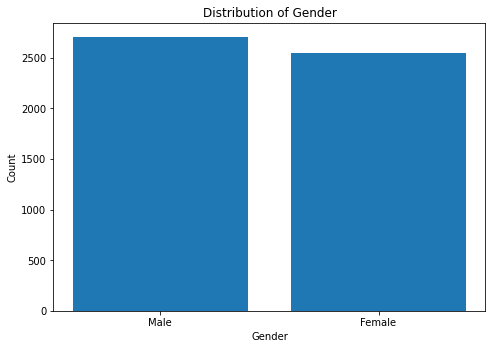

In [204]:
distribution_plot("gender", "Gender", ["Male", "Female"])

[0.0, 1.0, nan]


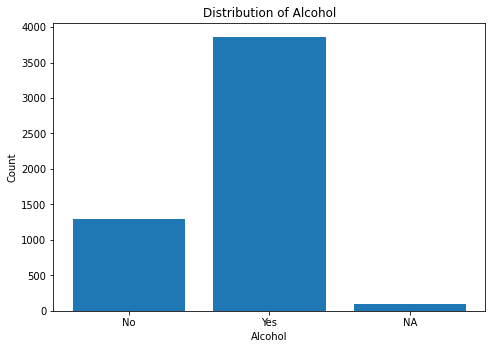

In [205]:
distribution_plot("alc", "Alcohol", ["No", "Yes", "NA"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 12]


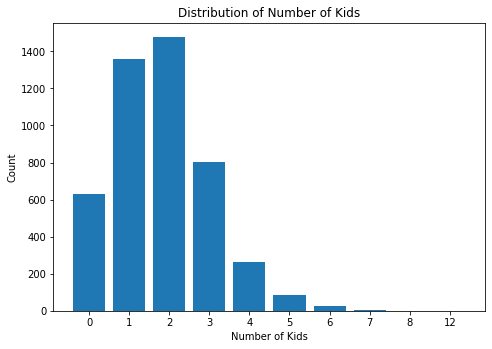

In [212]:
distribution_plot("n_kids", "Number of Kids")

Again, we see that Alcohol and Number of Kids contain a considerable number of NA values. Let's also remove them for the purpose of this tutorial. As we now checked all features we want to include in our analysis, we remove all rows containing missing values in one of our features within one line of code.

In [321]:
# Filter the dataset for rows which contain a value for smoke
nlsy_survey = nlsy_survey.dropna(subset=["n_kids", "alc", "health", "educ", "fruit"]).reset_index(drop=True)

In [282]:
nlsy_survey

,id,year,gender,ethnicity,educ_mo,educ_fa,citizen_birth,health,exercise,smoke,...,urban,educ,citizen_current,fruit,vegt,comp,tele,sleep,insured,age
0,5,2015,1,2,12,12,3,2,NaN,1,...,1,2,NaN,4,6,2,1,6,1,33
1,11,2015,2,2,14,12,1,4,NaN,1,...,1,4,NaN,2,3,6,2,5,1,33
2,16,2015,1,2,11,10,3,2,NaN,0,...,1,3,NaN,2,3,6,2,8,1,33
3,18,2015,1,1,15,10,1,1,NaN,1,...,1,1,NaN,5,5,4,3,7,1,33
4,20,2015,1,1,11,10,1,2,NaN,0,...,1,1,NaN,2,3,4,3,8,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,9014,2015,2,1,11,NaN,1,3,NaN,1,...,1,0,NaN,3,5,6,2,4,0,31
3504,9015,2015,2,1,12,12,1,2,NaN,0,...,1,2,NaN,2,4,6,2,6,1,35
3505,9018,2015,2,4,13,NaN,NaN,2,NaN,1,...,1,1,NaN,4,4,4,2,8,1,35
3506,9021,2015,1,4,14,NaN,1,3,NaN,1,...,1,4,NaN,3,3,6,4,6,1,35


Let's just keep the columns we really by selecting the respective columns and do a final check for any NA values in the remaining columns.

In [270]:
nlsy_survey = nlsy_survey[["smoke", "n_kids", "alc", "gender", "health", "educ"]]

nlsy_survey.isna().values.any()

False

#### Preprocessing

Let's continue with some basic preprocessing steps and a train-/testsplit for the upcoming models.

In [323]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() # functionality to replace categorie names of a feature with numbers (e.g. Sales = 0, Exec-managerial = 1,...)
nlsy_survey["gender"] = le.fit_transform(nlsy_survey["gender"])
nlsy_survey["alc"] = le.fit_transform(nlsy_survey["alc"])
nlsy_survey["n_kids"] = le.fit_transform(nlsy_survey["n_kids"])
nlsy_survey["health"] = le.fit_transform(nlsy_survey["health"])
nlsy_survey["educ"] = le.fit_transform(nlsy_survey["educ"])
nlsy_survey["smoke"] = le.fit_transform(nlsy_survey["smoke"])

In [284]:
nlsy_survey

,id,year,gender,ethnicity,educ_mo,educ_fa,citizen_birth,health,exercise,smoke,...,urban,educ,citizen_current,fruit,vegt,comp,tele,sleep,insured,age
0,5,2015,0,2,12,12,3,1,NaN,1,...,1,2,NaN,4,6,2,1,6,1,33
1,11,2015,1,2,14,12,1,3,NaN,1,...,1,4,NaN,2,3,6,2,5,1,33
2,16,2015,0,2,11,10,3,1,NaN,0,...,1,3,NaN,2,3,6,2,8,1,33
3,18,2015,0,1,15,10,1,0,NaN,1,...,1,1,NaN,5,5,4,3,7,1,33
4,20,2015,0,1,11,10,1,1,NaN,0,...,1,1,NaN,2,3,4,3,8,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,9014,2015,1,1,11,NaN,1,2,NaN,1,...,1,0,NaN,3,5,6,2,4,0,31
3504,9015,2015,1,1,12,12,1,1,NaN,0,...,1,2,NaN,2,4,6,2,6,1,35
3505,9018,2015,1,4,13,NaN,NaN,1,NaN,1,...,1,1,NaN,4,4,4,2,8,1,35
3506,9021,2015,0,4,14,NaN,1,2,NaN,1,...,1,4,NaN,3,3,6,4,6,1,35


In [324]:
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, RandomizedSearchCV

# Select features and split into train and test set
features=["gender", "alc", "n_kids", "health", "educ", "ethnicity"]

X_train, X_test, y_train, y_test = train_test_split(
    nlsy_survey[features], nlsy_survey["smoke"], test_size=0.2, random_state=20221216)

Let's take a look at the train-/testsplit:

In [297]:
X_train

,gender,alc,n_kids,smoke,educ,fruit
1036,0,0,3,1,1,2
2295,0,1,1,1,3,5
1607,0,1,1,0,2,2
1389,1,1,1,0,5,2
347,1,1,3,0,2,2
...,...,...,...,...,...,...
3082,1,1,5,0,0,2
609,0,1,0,1,0,4
884,1,1,3,0,5,2
145,1,0,3,0,2,5


In [298]:
y_train

1036    2
2295    3
1607    2
1389    1
347     1
       ..
3082    1
609     3
884     2
145     2
1264    2
Name: health, Length: 2806, dtype: int64

In [261]:
X_test

,gender,alc,n_kids
1198,1,1,3
3856,1,1,1
1555,0,0,2
4319,0,1,3
4077,1,1,2
...,...,...,...
1398,1,1,4
1112,0,1,1
1442,0,1,0
1957,0,0,1


In [262]:
y_test

1198    0
3856    0
1555    0
4319    1
4077    1
       ..
1398    0
1112    1
1442    0
1957    1
4130    1
Name: smoke, Length: 706, dtype: int64

### Logistic Regression in Python

### Random Forest in Python

https://towardsdatascience.com/interpreting-random-forest-and-other-black-box-models-like-xgboost-80f9cc4a3c38

In [325]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Train classifier with default parameters
clf = RandomForestClassifier(random_state=20220725)
clf.fit(X_train, y_train) # adapt the random forest algorithm to our training data

# Predict on test set
y_pred = clf.predict(X_test) # do an out-of-sample prediction on the test set using our trained classifier

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.6588443332341845


In [326]:
from scipy.stats import uniform, randint
import pandas as pd

param_grid = [
  {'n_estimators': randint(1,50),
   'criterion': ["gini", "entropy"],
   'max_depth': randint(1,50),
   'class_weight': ["balanced", None]}
  ]

# Set up Random Search
grid = RandomizedSearchCV(RandomForestClassifier(), 
                          param_distributions = param_grid, 
                          n_iter=100, 
                          verbose=1,
                          random_state=20221216, 
                          refit=True,
                          n_jobs=-1)

# Save results in dataframe
results = grid.fit(X_train, y_train)

# Print best params
print(grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'n_estimators': 37}


In [328]:
# Predict with best model
y_pred = results.best_estimator_.predict(X_test)

# Print results
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.680155450609996


### Conclusion